# FRED Data

In [1]:
import requests
import pandas
import numpy
import matplotlib.pyplot
from statsmodels.tsa.arima.model import ARIMA

### Inflation and CPI measures

Notes:

Collecting Monthly CPI from different categories to construct an ARIMA process that produces more accurate predctions of future overall CPI.

Suggestions: May not need to aggregate categorical CPI for one overall CPI prediction as certain stocks may correlate with certain CPIs.

In [2]:
def FRED_get_data(series_id):
    FRED_API_KEY = 'b4faab7a30a17140d246cce49bbf42ac'
    BASE_URL = 'https://api.stlouisfed.org/fred/series/observations'
    parameters = {'series_id': series_id,
                  'api_key': FRED_API_KEY,
                  'file_type': 'json'}
    response = requests.get(BASE_URL, params = parameters)
    if response.status_code == 200:
        data = response.json()
        observations = data['observations']
        df = pandas.DataFrame(observations)
        df = df[['date', 'value']]
        df['date'] = pandas.to_datetime(df['date'])
        df['value'] = pandas.to_numeric(df['value'], errors = 'coerce')
        df = df.rename(columns = {'value': series_id})
        return df
    else:
        print(f"Failed to fetch data. Status code: {response.status_code}")
        return None

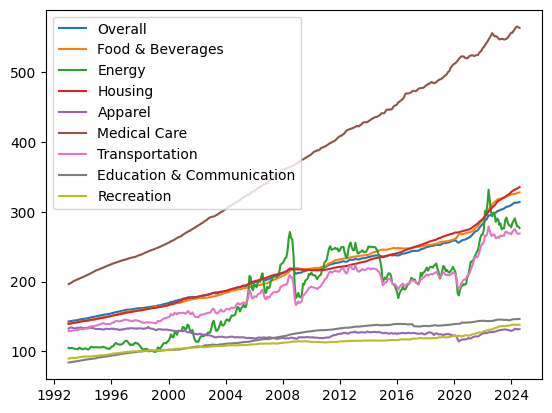

In [14]:
CPI_Categories = {'Overall': 'CPIAUCSL',
                  'Food & Beverages': 'CPIFABSL',
                  'Energy': 'CPIENGSL',
                  'Housing': 'CPIHOSSL',
                  'Apparel': 'CPIAPPSL',
                  'Medical Care': 'CPIMEDSL',
                  'Transportation':'CPITRNSL',
                  'Education & Communication': 'CPIEDUSL',
                  'Recreation': 'CPIRECSL'}

CPI_DataFrames = {category: FRED_get_data(series_id) for category, series_id in CPI_Categories.items()}

CPI = None
for category, dataframe in CPI_DataFrames.items():
    if CPI is None:
        CPI = dataframe
    else:
        CPI = pandas.merge(CPI, dataframe, on='date', how='inner')

for category, series_id in CPI_Categories.items():
    matplotlib.pyplot.plot(CPI['date'], CPI[series_id], label=category)
matplotlib.pyplot.legend()
matplotlib.pyplot.show()

In [4]:
n = numpy.sum([2,2,2]) # Lags [p,d,q] of ARIMA
v = CPI.shape[1]-2 # Exogenous Variables

m = 10
 
Y = []
B = []
X = []

for j in range(CPI.shape[0]-n-m*v*n+1):
    x = []
    for i in range(m*v*n):
        rows = []
        for category, series_id in list(CPI_Categories.items())[1:]:
            rows.append(numpy.array(CPI[series_id][j+i:j+i+n]))
        x.append(numpy.hstack((rows)))

    # y = b*x + e
    x = numpy.vstack((x)) # (v*n) x (v*n) matrix
    x = numpy.hstack([numpy.ones((x.shape[0], 1)), x]) # + b_0
    y = numpy.array(CPI['CPIAUCSL'][j+n:j+n+m*v*n]) # (v*n) x 1 matrix
    X.append(x), Y.append(y)

    # B = (x'wx)^-1(x'wy)
    w = numpy.diag(numpy.array([0.75**(k) for k in range(m*v*n)]))
    b = (numpy.linalg.inv(x.T @ w @ x)) @ (x.T @ w @ y)
    B.append(b)

Observed_CPI = []
Predicted_CPI = []
for l in range(CPI.shape[0]-n-m*v*n):
    Observed_CPI.append(Y[l+1][-1])
    Predicted_CPI.append(X[l+1][n*v-1] @ B[l])

### Nominal GDP

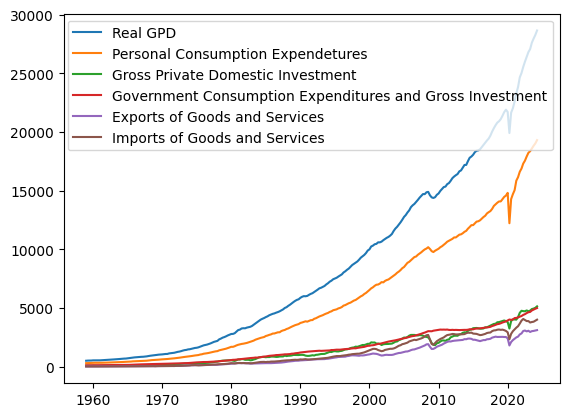

In [11]:
GDP_Variables = {'Real GPD': 'GDP',
                 'Personal Consumption Expendetures': 'PCE',
                 'Gross Private Domestic Investment': 'GPDI',
                 'Government Consumption Expenditures and Gross Investment': 'GCE',
                 'Exports of Goods and Services': 'EXPGS',
                 'Imports of Goods and Services': 'IMPGS'}

GDP_DataFrames = {category: FRED_get_data(series_id) for category, series_id in GDP_Variables.items()}

GDP = None
for category, dataframe in GDP_DataFrames.items():
    if GDP is None:
        GDP = dataframe
    else:
        GDP = pandas.merge(GDP, dataframe, on='date', how='inner')

for variable, series_id in GDP_Variables.items():
    matplotlib.pyplot.plot(GDP['date'], GDP[series_id], label=variable)
matplotlib.pyplot.legend()
matplotlib.pyplot.show()

### Treasury Yields

In [6]:
def TD_get_data(variables, terms):
    if isinstance(variables, list):
        param_variables = ','.join(variables)
    if isinstance(terms, list):
        param_terms = ','.join(terms)
    BASE_URL = "https://api.fiscaldata.treasury.gov/services/api/fiscal_service"
    ENDPOINT = "/v1/accounting/od/auctions_query"
    parameters = {'fields': param_variables,
                  'filter': 'security_term:in:(' + param_terms + ')',
                  'page[size]': '10000',
                  'format': 'json'}
    response = requests.get(BASE_URL+ENDPOINT, params = parameters)
    if response.status_code == 200:
        data = response.json()
        df = pandas.json_normalize(data['data'])
        df = df[variables]
        df['issue_date'] = pandas.to_datetime(df['issue_date'])
        df['price_per100'] = (100/pandas.to_numeric(df['price_per100'], errors = 'coerce'))-1
        df = df.pivot_table(index='issue_date',
                            columns='security_term',
                            values='price_per100',
                            aggfunc='first').reset_index()
        df['13-Week'] = df['13-Week'] * (365/91) * 100
        df['26-Week'] = df['26-Week'] * (365/182) * 100
        return df
    else:
        print(f"Failed to fetch data. Status code: {response.status_code}")
        return None

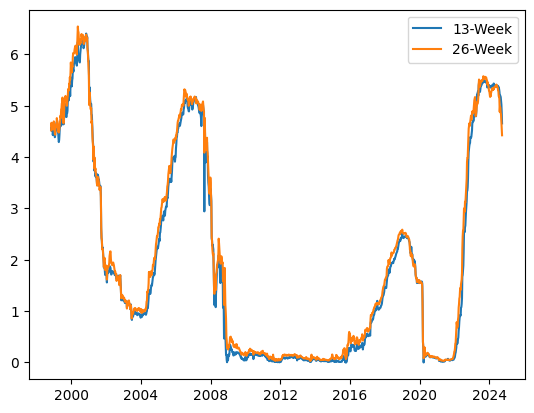

In [7]:
Treasury = TD_get_data(['security_term','issue_date','price_per100'], ['13-Week','26-Week'])
matplotlib.pyplot.plot(Treasury['issue_date'], Treasury['13-Week'], label='13-Week')
matplotlib.pyplot.plot(Treasury['issue_date'], Treasury['26-Week'], label='26-Week')
matplotlib.pyplot.legend()
matplotlib.pyplot.show()

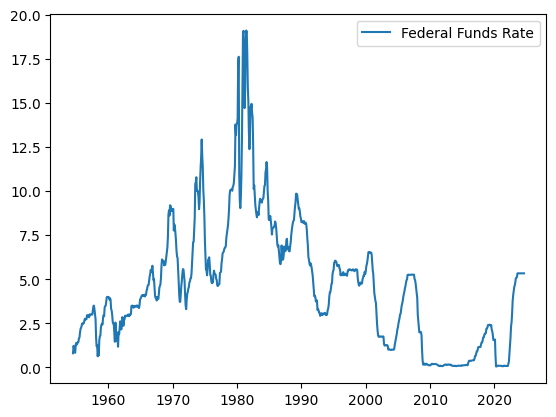

In [16]:
Labor_Market_Categories = {'Unemployment Rate': 'UNRATE',
                           'Labor Force Participation Rate': 'CIVPART',
                           'Initial Jobless Claims': 'ICSA',
                           'Continuing Jobless Claims': 'CCSA',
                           'Job Openings': 'JTSJOL'}
Labor_Ratios_Categories = {'Employment-Population Ratio': 'EMRATIO',
                           'Quits Rate': 'JTSQUR',
                           'Hires Rate': 'JTSHIR',
                           'Layoffs Rate': 'JTSJOL',
                           'Separations Rate': 'JTSSOL',
                           'Job Openings Rate (Non-Farm)': 'JTSJOR'}
# Job Openings Rate can be expanded to include all categories

FED_Categories = {'Federal Funds Rate': 'FEDFUNDS'}

Monetary_Policy_Categories = {'Federal Funds Rate': 'FEDFUNDS',
                              'M1 Money Stock': 'M1',
                              'M2 Money Stock': 'M2',
                              'Velocity of Money (M1)': 'M1V',
                              'Velocity of Money (M2)': 'M2V',
                              'Monetary Base': 'BOGMBASE',
                              'Currency in Circulation': 'CURRCIR'}

Marginal_Categories = {'Marginal Productivity of Labor': 'MPU4910063',
                       'Marginal Productivity of Capital': 'MPU4910061',
                       'Marginal Cost of Labor': 'MPU4910067',
                       'Marginal Cost of Capital': 'MPU4910069'}


FED_Dataframes = {category: FRED_get_data(series_id) for category, series_id in FED_Categories.items()}

FED = None
for category, dataframe in FED_Dataframes.items():
    if FED is None:
        FED = dataframe
    else:
        FED = pandas.merge(FED, dataframe, on='date', how='inner')

for variable, series_id in FED_Categories.items():
    matplotlib.pyplot.plot(FED['date'], FED[series_id], label=variable)
matplotlib.pyplot.legend()
matplotlib.pyplot.show()